In [2]:
import os
import sys
import json
import joblib
import geopandas as gpd
import torch
import help_functions as hf

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn  # or whatever you need to import
import help_functions as hf

<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [8]:
# Parameters to adapt

run_path = '../../data/runs_21_10_2024/'
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512,256" 
# for new model, remove last 256
dropout = 0.3
use_dropout = False 
predict_mode_stats = False
in_channels = 13
out_channels = 1 
loss_fct = torch.nn.MSELoss()

# The rest we can usually leave as is
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
pnc_l_string = point_net_conv_layer_structure_local_mlp.replace(',', '_')
pnc_g_string = point_net_conv_layer_structure_global_mlp.replace(',', '_') 
gat_string = gat_conv_layer_structure.replace(',', '_')

unique_model_description = f"pnc_local_[{pnc_l_string}]_" + \
f"pnc_global_[{pnc_g_string}]_" + \
f"gat_conv_[{gat_string}]_" + \
f"use_dropout_{use_dropout}_" + \
f"dropout_{dropout}_" + \
f"predict_mode_stats_{predict_mode_stats}" + "/"
        
run_path = run_path + unique_model_description
base_case_path = '../../data/test_data/pop_1pm_basecase_mean_links_NEW.geojson'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

In [9]:
# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [10]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_3): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_

In [11]:
test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

print(f"Test Loss: {test_loss_my_test_data}")
print(f"R-squared: {r_squared_my_test_data}")
print(f"Baseline Loss: {baseline_loss_my_test_data}")

Test Loss: 1.5650740226269728
R-squared: 0.4639238715171814
Baseline Loss: 2.919499158859253


# Next, we will look at single elements of the test set and visualize the performance of the model.


Test 0
Test Loss: 0.21610869963963827
R-squared: 0.5186114311218262
Baseline Loss: 2.6935665607452393


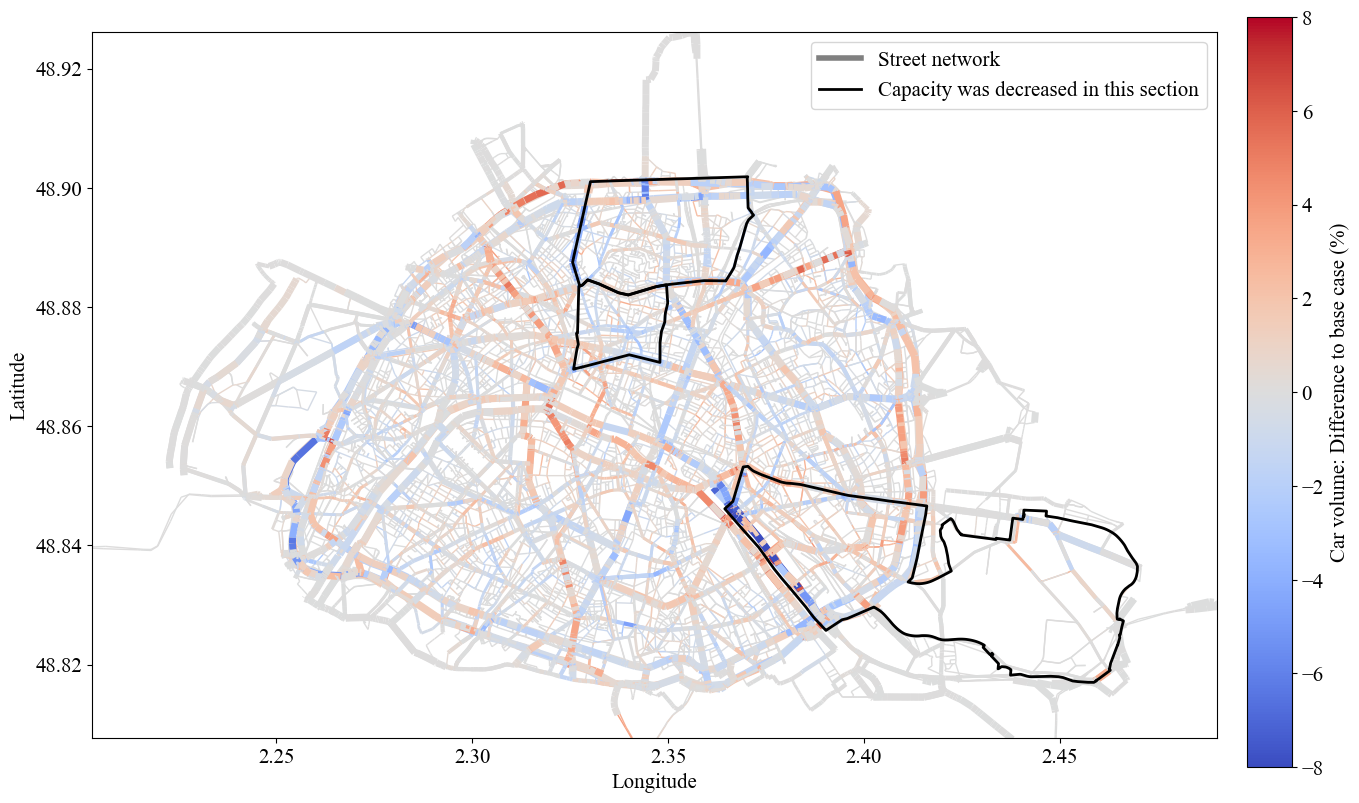

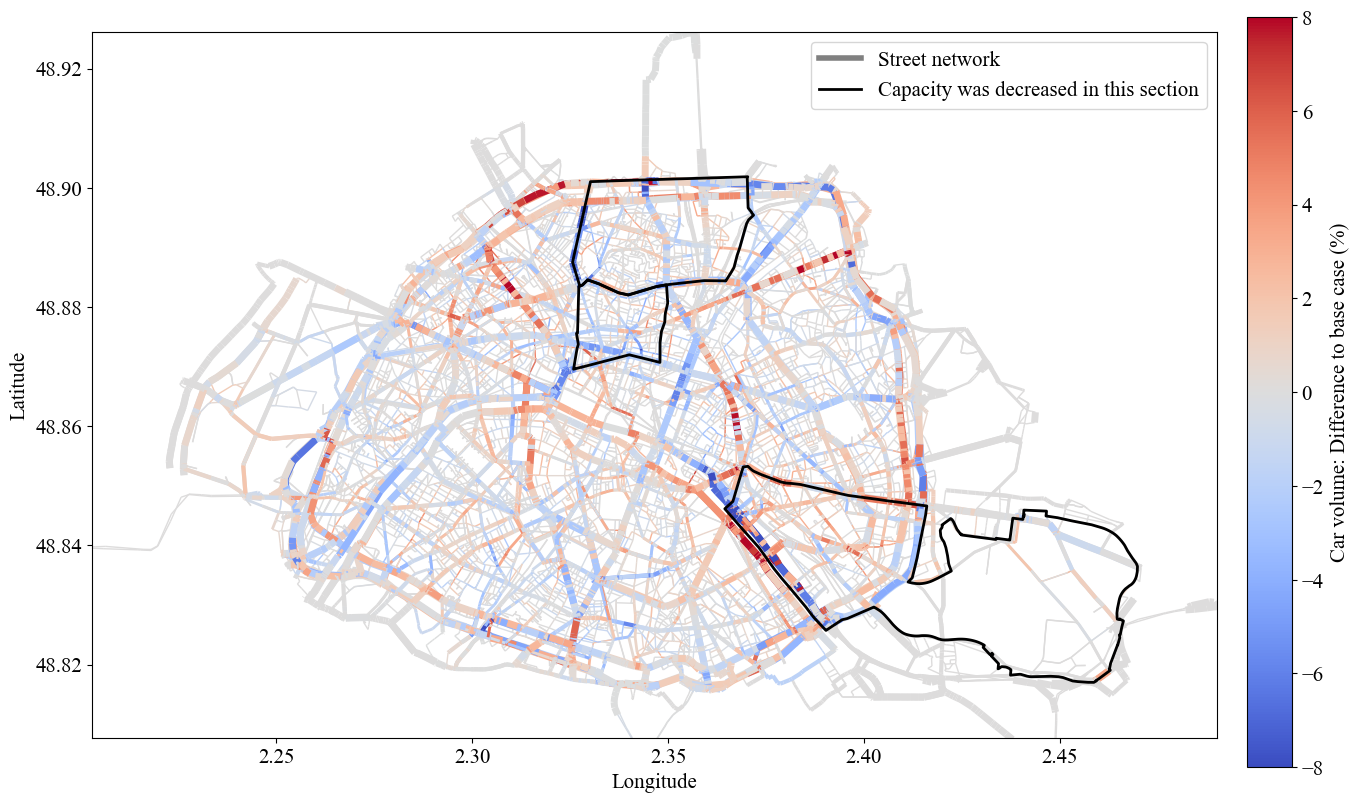

In [12]:
fixed_norm_max = 8

i = 0

my_test_data = test_set_loader.dataset[i]
my_test_x = test_set_loader.dataset[i].x
my_test_x = my_test_x.to('cpu')

test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
print(f"Test {i}")
print(f"Test Loss: {test_loss_my_test_data}")
print(f"R-squared: {r_squared_my_test_data}")
print(f"Baseline Loss: {baseline_loss_my_test_data}")

inversed_x = scaler_x.inverse_transform(my_test_x)

gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                        save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
                        number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None)

In [24]:
predictions_my_test_data

tensor([[ 0.0021],
        [ 0.0021],
        [ 0.0031],
        ...,
        [-0.0001],
        [ 0.0004],
        [ 0.0006]], device='cuda:0')

        from_node     to_node  vol_base_case  capacity_base_case  \
164    1030161702    94184450      13.607843              1200.0   
165    1030161704  3691022395      22.784314              1200.0   
170    1033927705   153503455      15.960784              1600.0   
171    1033927705   251768038       0.568627               480.0   
173    1035711019      367940      14.254902              1200.0   
...           ...         ...            ...                 ...   
29082    94251344    94239966       2.117647               480.0   
29084    94251346    94239970       5.058824               800.0   
29085    94251346    94250560       6.647059               800.0   
29109    94252521  1030161702      16.117647              1200.0   
29601   979091346      361116      10.137255              3600.0   

       capacities_new  capacity_reduction  freespeed  highway      length  \
164             600.0              -600.0   8.333333      1.0   18.277716   
165             600.0        

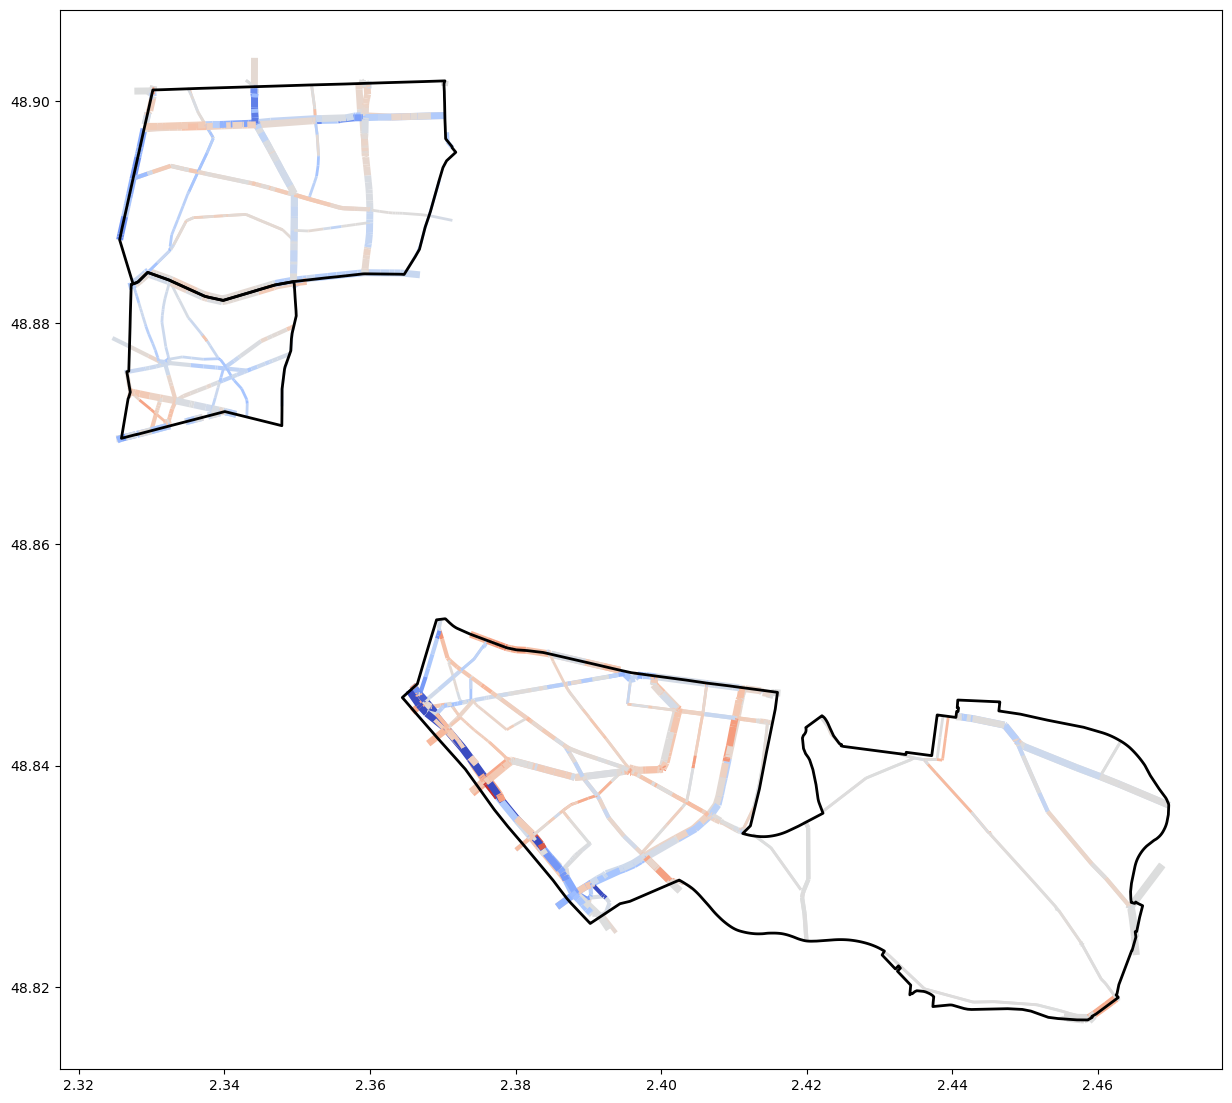

In [23]:
# gdf_with_og_values.head(50)

non_zero_capacity_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction'] != 0]
print(non_zero_capacity_reduction)


# def plot_combined_output(gdf_input: gpd.GeoDataFrame, column_to_plot: str, font: str = 'Times New Roman', 
#                          save_it: bool = False, number_to_plot: int = 0,
#                          zone_to_plot:str= "this_zone",
#                          is_predicted: bool = False, alpha:int=100, 
#                          use_fixed_norm:bool=True, 
#                          fixed_norm_max: int= 10, normalized_y:bool=False, known_districts:bool=False, buffer: float = 0.0005, districts_of_interest: list =[1, 2, 3, 4]):

gdf_input=non_zero_capacity_reduction
column_to_plot="vol_car_change_predicted"
save_it=False,
number_to_plot=i
zone_to_plot = "this zone"
is_predicted=True
alpha=0
use_fixed_norm=True
fixed_norm_max = fixed_norm_max
known_districts = False
buffer = 0.0005
districts_of_interest=None

gdf = gdf_input.copy()
print(gdf.head(5))
# gdf, x_min, y_min, x_max, y_max = hf.filter_for_geographic_section(gdf)

print(gdf.head(5))
fig, ax = hf.plt.subplots(1, 1, figsize=(15, 15))    
if use_fixed_norm:
    norm = hf.TwoSlopeNorm(vmin=-fixed_norm_max, vcenter=0, vmax=fixed_norm_max)
else:
    norm = hf.TwoSlopeNorm(vmin=gdf[column_to_plot].min(), vcenter=gdf[column_to_plot].median(), vmax=gdf[column_to_plot].max())

linewidths = gdf["highway"].apply(hf.get_linewidth)
gdf['linewidth'] = linewidths
large_lines = gdf[gdf['linewidth'] > 1]
small_lines = gdf[gdf['linewidth'] == 1]
# small_lines.plot(column=column_to_plot, cmap='coolwarm', linewidth=small_lines['linewidth'], ax=ax, legend=False,
#                 norm=norm, label="Street network", zorder=1)
large_lines.plot(column=column_to_plot, cmap='coolwarm', linewidth=large_lines['linewidth'], ax=ax, legend=False,
                norm=norm, label="Street network", zorder=2)

relevant_area_to_plot = hf.get_relevant_area_to_plot(alpha, known_districts, buffer, districts_of_interest, gdf)

if isinstance(relevant_area_to_plot, set):
    for area in relevant_area_to_plot:
        if isinstance(area, hf.Polygon):
            gdf_area = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[area])
            gdf_area.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2)
else:
    relevant_area_to_plot.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2)
    
# cbar = hf.plotting(font, x_min, y_min, x_max, y_max, fig, ax, norm)
# cbar.set_label('Car volume: Difference to base case (%)', fontname=font, fontsize=15)
# if save_it:
#     p = "predicted" if is_predicted else "actual"
    # identifier = "n_" + str(number_to_plot) if number_to_plot is not None else zone_to_plot
    # hf.plt.savefig("results/" + identifier + "_" + p, bbox_inches='tight')
hf.plt.show()
    




In [20]:
non_zero_capacity_reduction

,from_node,to_node,vol_base_case,capacity_base_case,capacities_new,capacity_reduction,freespeed,highway,length,allowed_mode_car,allowed_mode_bus,allowed_mode_pt,allowed_mode_train,allowed_mode_rail,allowed_mode_subway,vol_car_change_actual,vol_car_change_predicted,geometry,capacity_reduction_rounded
164,1030161702,94184450,13.607843,1200.0,600.0,-600.0,8.333333,1.0,18.277716,1.0,1.0,1.0,3.469447e-18,0.0,0.0,1.392157,0.515429,"LINESTRING (2.35965 48.88667, 2.35968 48.88683)",-600.0
165,1030161704,3691022395,22.784314,1200.0,600.0,-600.0,8.333333,1.0,92.128262,1.0,1.0,1.0,3.469447e-18,0.0,0.0,-0.784314,-1.360927,"LINESTRING (2.35978 48.88720, 2.35991 48.88802)",-600.0
170,1033927705,153503455,15.960784,1600.0,800.0,-800.0,8.333333,2.0,13.766448,1.0,1.0,1.0,3.469447e-18,0.0,0.0,-0.960784,0.491435,"LINESTRING (2.37397 48.84794, 2.37382 48.84801)",-800.0
171,1033927705,251768038,0.568627,480.0,240.0,-240.0,8.333333,3.0,9.493971,1.0,1.0,1.0,3.469447e-18,0.0,0.0,-0.568627,-0.355495,"LINESTRING (2.37397 48.84794, 2.37389 48.84787)",-240.0
173,1035711019,367940,14.254902,1200.0,600.0,-600.0,8.333333,1.0,60.459082,1.0,1.0,1.0,3.469447e-18,0.0,0.0,-3.254902,-1.614882,"LINESTRING (2.36421 48.88450, 2.36338 48.88451)",-600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29082,94251344,94239966,2.117647,480.0,240.0,-240.0,8.333333,3.0,150.062839,1.0,0.0,0.0,3.469447e-18,0.0,0.0,-0.117647,0.385863,"LINESTRING (2.35357 48.88848, 2.35154 48.88830)",-240.0
29084,94251346,94239970,5.058824,800.0,400.0,-400.0,8.333333,2.0,122.168001,1.0,1.0,1.0,3.469447e-18,0.0,0.0,-2.058824,1.713019,"LINESTRING (2.35322 48.89089, 2.35162 48.89118)",-400.0
29085,94251346,94250560,6.647059,800.0,400.0,-400.0,8.333333,2.0,99.929061,1.0,1.0,1.0,3.469447e-18,0.0,0.0,-0.647059,1.616314,"LINESTRING (2.35322 48.89089, 2.35453 48.89065)",-400.0
29109,94252521,1030161702,16.117647,1200.0,600.0,-600.0,8.333333,1.0,63.220559,1.0,1.0,1.0,3.469447e-18,0.0,0.0,0.882353,0.944789,"LINESTRING (2.35953 48.88611, 2.35965 48.88667)",-600.0


In [8]:
indices_roads_with_highway_primary_sec_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([1,2,3])].index
indices_roads_with_highway_primary_ = gdf_with_og_values[gdf_with_og_values['highway'].isin([1])].index
indices_roads_with_highway_sec = gdf_with_og_values[gdf_with_og_values['highway'].isin([2])].index
indices_roads_with_highway_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([3])].index
indices_roads_with_highway_not_primary_sec_tertiary = gdf_with_og_values[~gdf_with_og_values['highway'].isin([1, 2, 3])].index

tolerance = 1e-3
indices_roads_with_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] < -1e-3].index
indices_roads_with_no_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3].index

indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
].index

def validate_model_on_indices(indices, gdf, loss_fct, loss_fct_aux):
    actual_vals = gdf.loc[indices, 'vol_car_change_actual']
    predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
    actual_vals = actual_vals.to_numpy()
    predicted_vals = predicted_vals.to_numpy()
    actual_mean = torch.mean(torch.tensor(actual_vals))
    mse = loss_fct(torch.tensor(actual_vals), torch.tensor(predicted_vals))
    baseline = loss_fct(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
    variance = torch.var(loss_fct_aux(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean)))
    r_squared = hf.compute_r2_torch(preds=torch.tensor(predicted_vals), targets=torch.tensor(actual_vals))
    
    baseline = round(baseline.item(), 2)
    mse = round(mse.item(), 2)
    r_squared = round(r_squared.item(), 2)
    variance = round(variance.item(), 2)
    return baseline, mse, r_squared, variance

loss_fct_aux = torch.nn.MSELoss(reduction='none')

baseline_primary_sec_tertiary, mse_primary_sec_tertiary, r_squared_primary_sec_tertiary, variance_primary_sec_tertiary = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_primary, mse_primary, r_squared_primary, variance_primary = validate_model_on_indices(indices_roads_with_highway_primary_, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_sec, mse_sec, r_squared_sec, variance_sec = validate_model_on_indices(indices_roads_with_highway_sec, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_tertiary, mse_tertiary, r_squared_tertiary, variance_tertiary = validate_model_on_indices(indices_roads_with_highway_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_not_primary_sec_tertiary, mse_not_primary_sec_tertiary, r_squared_not_primary_sec_tertiary, variance_not_primary_sec_tertiary = validate_model_on_indices(indices_roads_with_highway_not_primary_sec_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_cap_reduction, mse_cap_reduction, r_squared_cap_reduction, variance_cap_reduction = validate_model_on_indices(indices_roads_with_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_no_cap_reduction, mse_no_cap_reduction, r_squared_no_cap_reduction, variance_no_cap_reduction = validate_model_on_indices(indices_roads_with_no_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_primary_sec_tertiary_and_cap_reduction, mse_primary_sec_tertiary_and_cap_reduction, r_squared_primary_sec_tertiary_and_cap_reduction, variance_primary_sec_tertiary_and_cap_reduction = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
baseline_primary_sec_tertiary_and_not_cap_reduction, mse_primary_sec_tertiary_and_not_cap_reduction, r_squared_primary_sec_tertiary_and_not_cap_reduction, variance_primary_sec_tertiary_and_not_cap_reduction = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)

print("Primary, Secondary, Tertiary Roads - Baseline:", baseline_primary_sec_tertiary, "MSE:", mse_primary_sec_tertiary, "R^2:", r_squared_primary_sec_tertiary, "Variance:", variance_primary_sec_tertiary)
print("Primary Roads - Baseline:", baseline_primary, "MSE:", mse_primary, "R^2:", r_squared_primary, "Variance:", variance_primary)
print("Secondary Roads - Baseline:", baseline_sec, "MSE:", mse_sec, "R^2:", r_squared_sec, "Variance:", variance_sec)
print("Tertiary Roads - Baseline:", baseline_tertiary, "MSE:", mse_tertiary, "R^2:", r_squared_tertiary, "Variance:", variance_tertiary)
print("Non-Primary, Non-Secondary, Non-Tertiary Roads - Baseline:", baseline_not_primary_sec_tertiary, "MSE:", mse_not_primary_sec_tertiary, "R^2:", r_squared_not_primary_sec_tertiary, "Variance:", variance_not_primary_sec_tertiary)
print("Capacity Reduction Roads - Baseline:", baseline_cap_reduction, "MSE:", mse_cap_reduction, "R^2:", r_squared_cap_reduction, "Variance:", variance_cap_reduction)
print("No Capacity Reduction Roads - Baseline:", baseline_no_cap_reduction, "MSE:", mse_no_cap_reduction, "R^2:", r_squared_no_cap_reduction, "Variance:", variance_no_cap_reduction)
print("Primary, Secondary, Tertiary Roads with Capacity Reduction - Baseline:", baseline_primary_sec_tertiary_and_cap_reduction, "MSE:", mse_primary_sec_tertiary_and_cap_reduction, "R^2:", r_squared_primary_sec_tertiary_and_cap_reduction, "Variance:", variance_primary_sec_tertiary_and_cap_reduction)
print("Primary, Secondary, Tertiary Roads with No Capacity Reduction - Baseline:", baseline_primary_sec_tertiary_and_not_cap_reduction, "MSE:", mse_primary_sec_tertiary_and_not_cap_reduction, "R^2:", r_squared_primary_sec_tertiary_and_not_cap_reduction, "Variance:", variance_primary_sec_tertiary_and_not_cap_reduction)

# Convert the GeoDataFrame to the appropriate coordinate reference system (CRS) for length calculation
gdf_in_meters = gdf_with_og_values.to_crs("EPSG:32633")
gdf_in_meters['length'] = gdf_in_meters.length
total_length = gdf_in_meters['length'].sum() / 1000
print(f"Total length of the street network: {total_length:.2f} km")
gdf_with_reductions = gdf_in_meters.loc[indices_roads_with_cap_reduction]
total_length_with_reductions = gdf_with_reductions['length'].sum() / 1000
print(f"Total length of the street network with capacity reductions: {total_length_with_reductions:.2f} km")
# Can do this for all indices

torch.Size([13189])
torch.Size([5147])
torch.Size([4273])
torch.Size([3769])
torch.Size([17951])
torch.Size([1982])
torch.Size([29158])
torch.Size([1982])
torch.Size([11207])
Primary, Secondary, Tertiary Roads - Baseline: 4.54 MSE: 2.91 R^2: 0.36 Variance: 117.36
Primary Roads - Baseline: 6.47 MSE: 4.15 R^2: 0.36 Variance: 191.81
Secondary Roads - Baseline: 3.25 MSE: 2.2 R^2: 0.32 Variance: 57.28
Tertiary Roads - Baseline: 3.19 MSE: 2.01 R^2: 0.37 Variance: 55.96
Non-Primary, Non-Secondary, Non-Tertiary Roads - Baseline: 1.17 MSE: 0.88 R^2: 0.25 Variance: 24.23
Capacity Reduction Roads - Baseline: 8.01 MSE: 4.2 R^2: 0.48 Variance: 169.48
No Capacity Reduction Roads - Baseline: 2.21 MSE: 1.57 R^2: 0.29 Variance: 55.23
Primary, Secondary, Tertiary Roads with Capacity Reduction - Baseline: 8.01 MSE: 4.2 R^2: 0.48 Variance: 169.48
Primary, Secondary, Tertiary Roads with No Capacity Reduction - Baseline: 3.87 MSE: 2.68 R^2: 0.31 Variance: 98.59
Total length of the street network: 2829.98 km